In [197]:
import sys
import warnings

warnings.filterwarnings("ignore")
from itertools import product
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from scipy.optimize import minimize
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm.notebook import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
%matplotlib inline


from plotly import __version__
from plotly import graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

init_notebook_mode(connected=True)

In [198]:
train_data = pd.read_csv("train.csv", parse_dates=["Date"])
test_data = pd.read_csv("test.csv", parse_dates=["Date"])

In [190]:
dataset.describe()

,Store,Date,Temperature,Fuel_Price,CPI,Unemployment
count,180.0000,180,180.000000,180.000000,180.000000,180.000000
mean,23.0000,2012-11-07 00:00:00,61.234278,3.859478,176.391244,7.070167
min,1.0000,2012-10-19 00:00:00,39.380000,3.494000,131.108333,3.879000
25%,12.0000,2012-10-24 06:00:00,53.570000,3.601000,138.088267,6.034000
50%,23.0000,2012-10-31 00:00:00,60.065000,3.809000,191.642658,6.943000
75%,34.0000,2012-11-13 18:00:00,70.610000,4.029000,222.062102,8.173250
max,45.0000,2012-12-10 00:00:00,81.020000,4.468000,227.232807,11.627000
std,13.0234,NaN,10.530203,0.269139,41.176313,1.636277


In [191]:
dataset.head()

,Store,Date,Temperature,Fuel_Price,CPI,Unemployment
0,1,2012-10-19,67.97,3.594,223.425723,6.573
1,1,2012-10-26,69.16,3.506,223.444251,6.573
2,1,2012-11-05,73.77,3.688,221.725663,7.143
3,1,2012-12-10,62.99,3.601,223.381296,6.573
4,2,2012-10-19,68.08,3.594,223.059808,6.170


In [192]:
print(dataset.isna().sum())
print(dataset.isnull().any())

Store           0
Date            0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64
Store           False
Date            False
Temperature     False
Fuel_Price      False
CPI             False
Unemployment    False
dtype: bool


Анализ временного ряда для магазинов: 1, 2, 3, 4, 5


KeyError: 'Weekly_Sales'

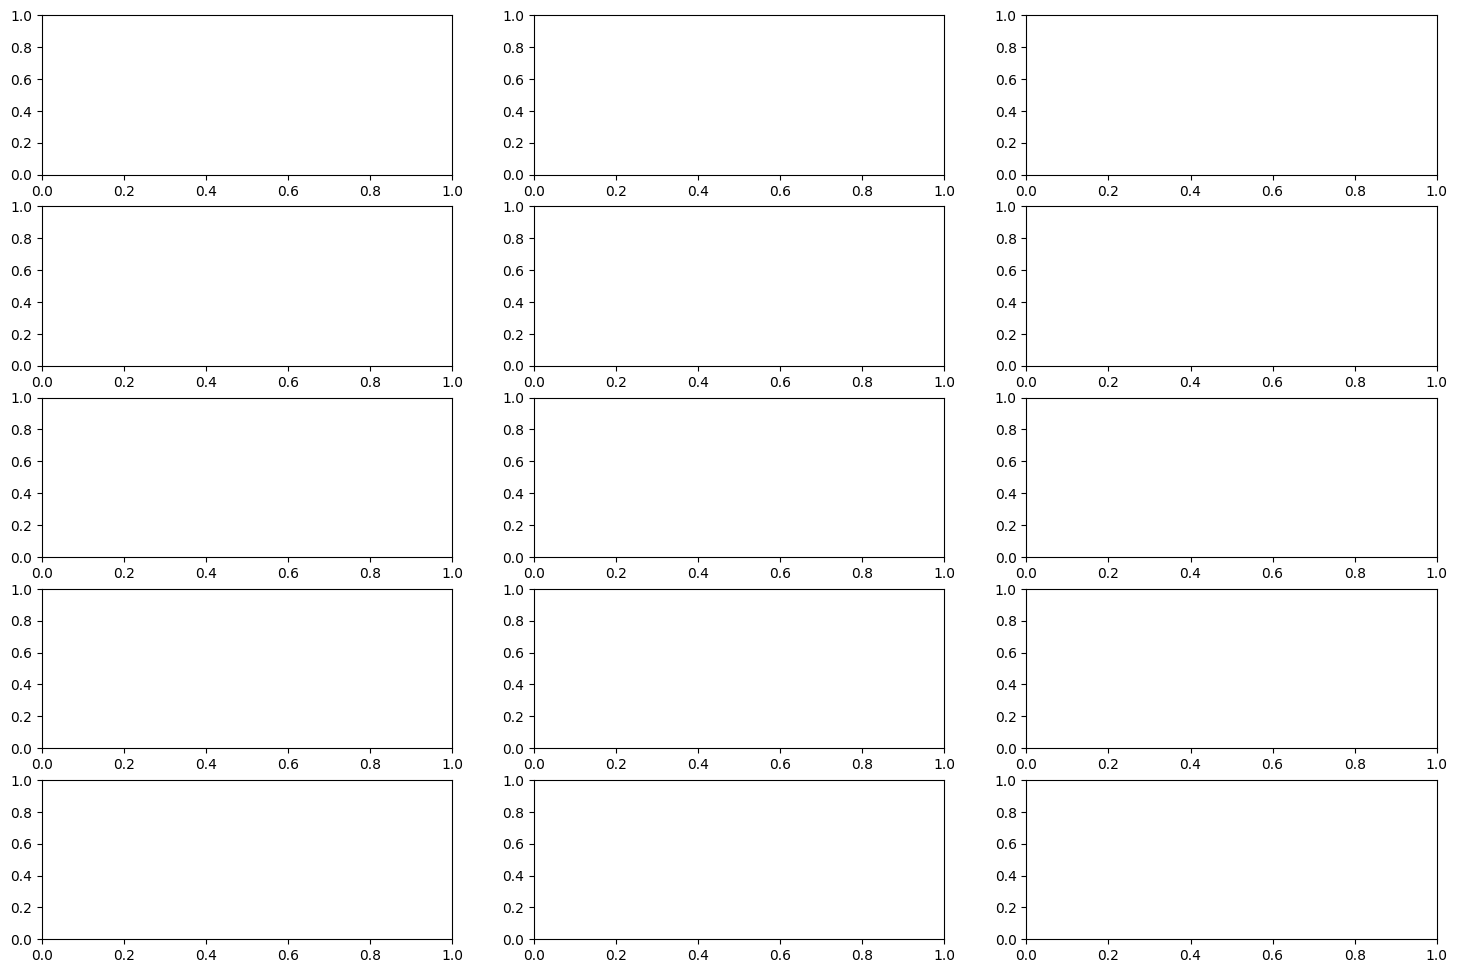

In [ ]:
def tsplot(y, lags=None, axes=None):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    p_value = sm.tsa.stattools.adfuller(y)[1]

    axes[0].plot(y)
    axes[0].set_title("Dickey-Fuller: p={0:.5f}".format(p_value))

    smt.graphics.plot_acf(y, lags=lags, ax=axes[1])
    smt.graphics.plot_pacf(y, lags=lags, ax=axes[2])


stores = dataset['Store'].unique()

stores_per_page = 5
figsize = (18, 12)
lags = 30 


for i in range(0, len(stores), stores_per_page):
    fig, axs = plt.subplots(stores_per_page, 3, figsize=figsize)
    
    current_stores = stores[i:i + stores_per_page]
    print(f'Анализ временного ряда для магазинов: {", ".join(map(str, current_stores))}')
    
    for j in range(stores_per_page):
        if i + j < len(stores):
            store = stores[i + j]
            store_data = dataset[dataset['Store'] == store].set_index('Date')['Weekly_Sales']
            
            axes_row = axs[j, :]
            
            tsplot(store_data, lags=lags, axes=axes_row)
    
    plt.tight_layout()
    plt.show()

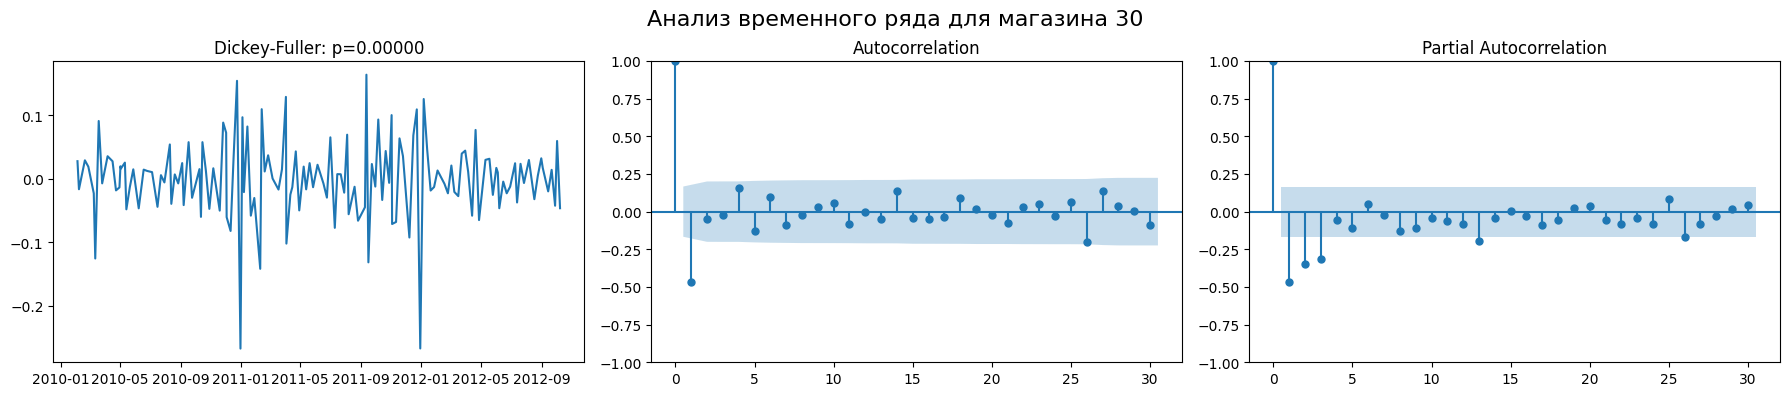

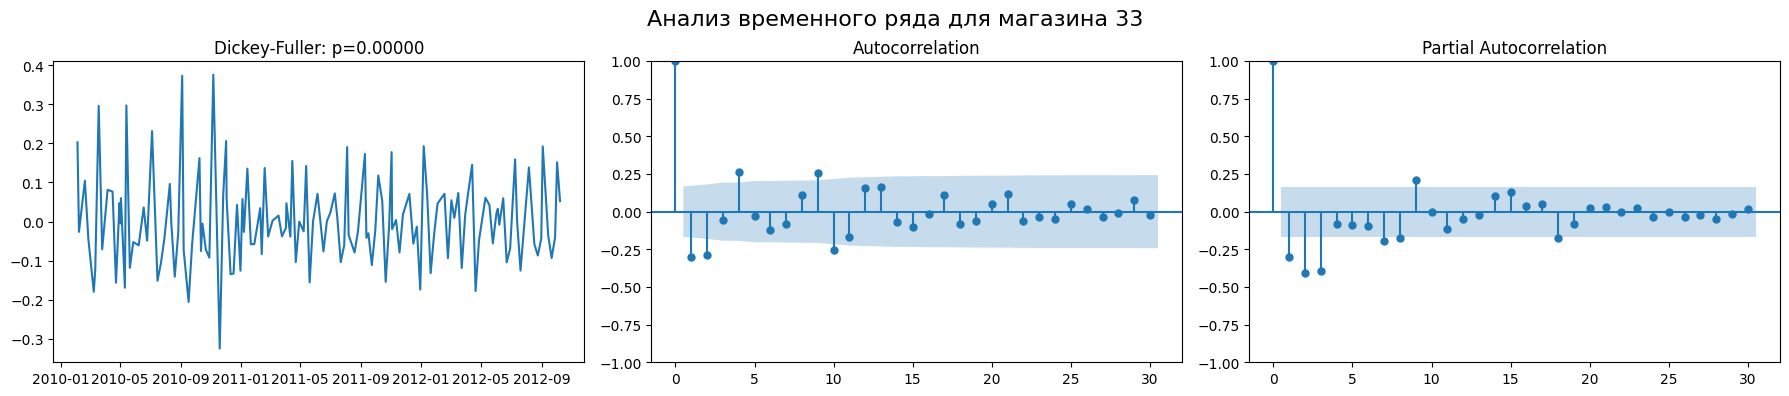

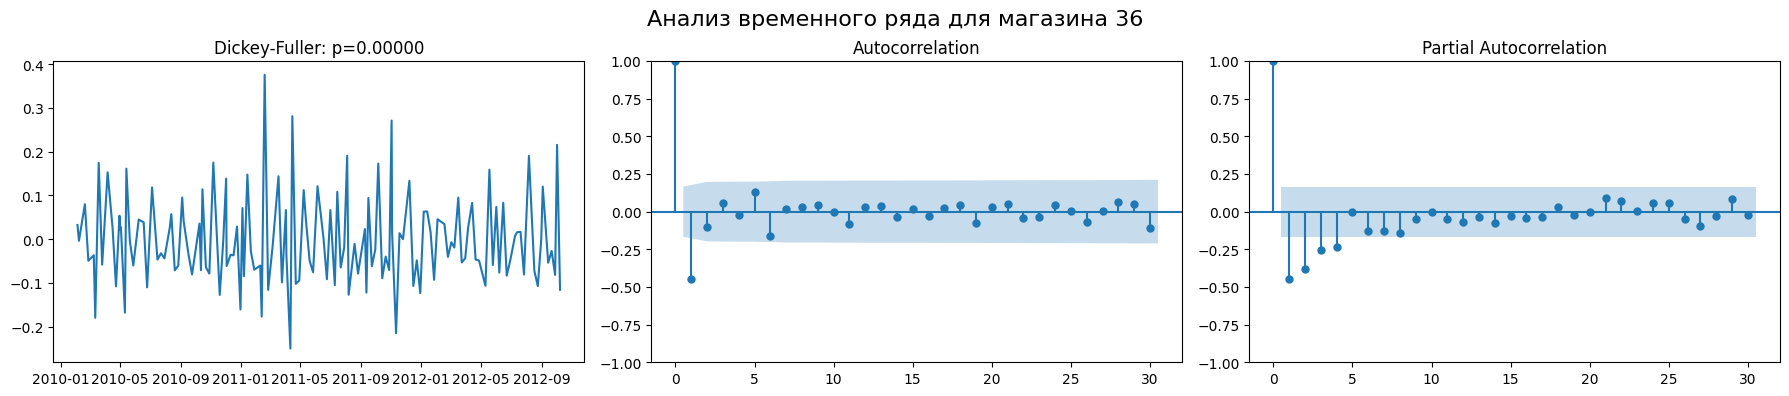

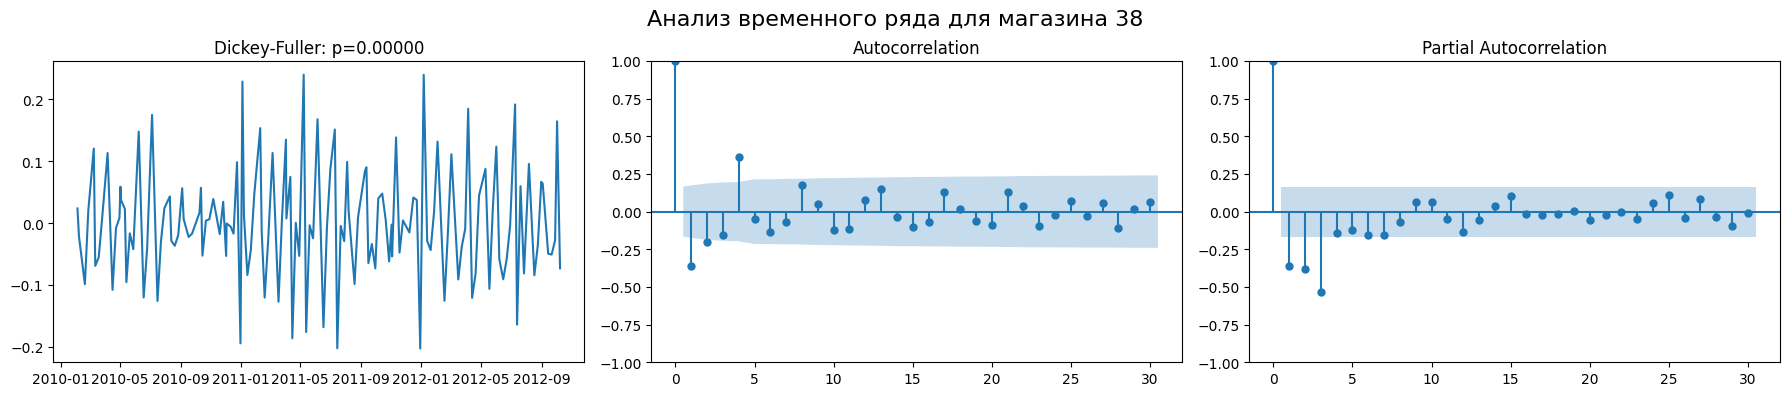

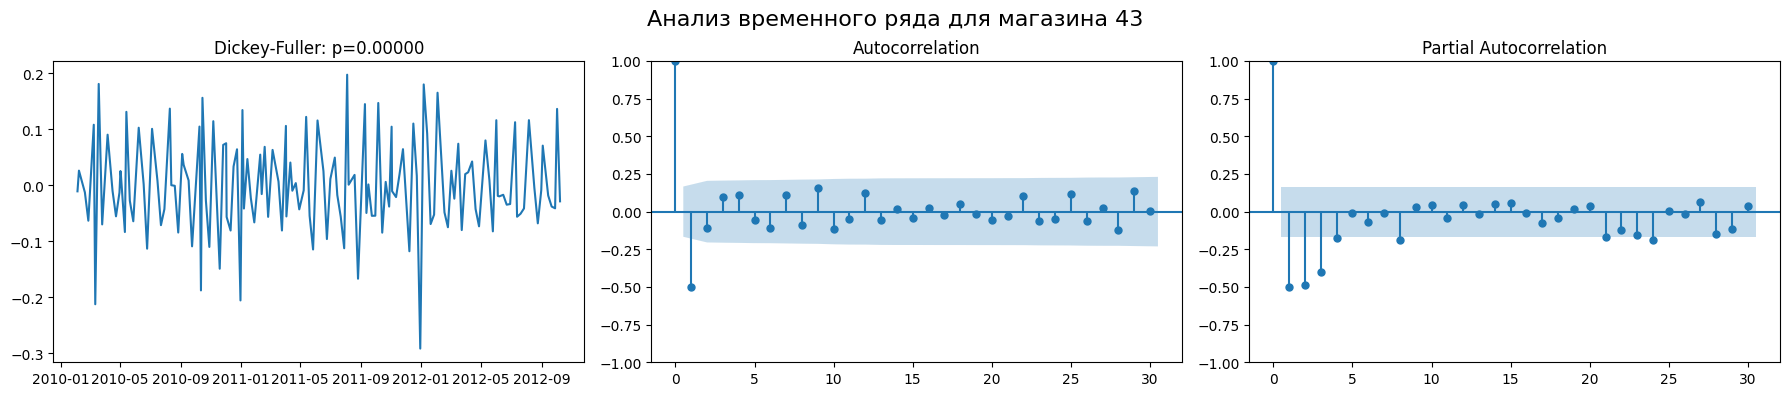

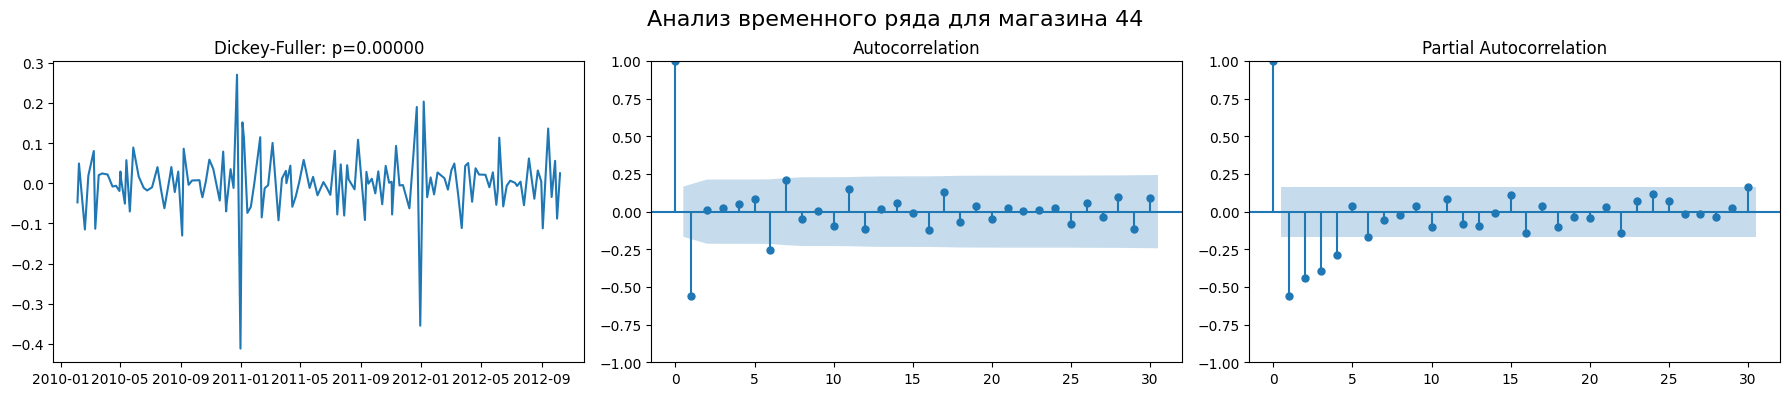

In [ ]:
stores_to_analyze = [30, 33, 36, 38, 43, 44]


lags = 30
figsize = (18, 4)


for store in stores_to_analyze:
    store_data = dataset[dataset['Store'] == store].set_index('Date')['Weekly_Sales']
    
    log_store_data = np.log(store_data + 1)

    diff_log_store_data = log_store_data.diff().dropna()

    fig, axs = plt.subplots(1, 3, figsize=figsize)
    fig.suptitle(f'Анализ временного ряда для магазина {store}', fontsize=16)
    tsplot(diff_log_store_data, lags=lags, axes=axs)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85) 
    plt.show()

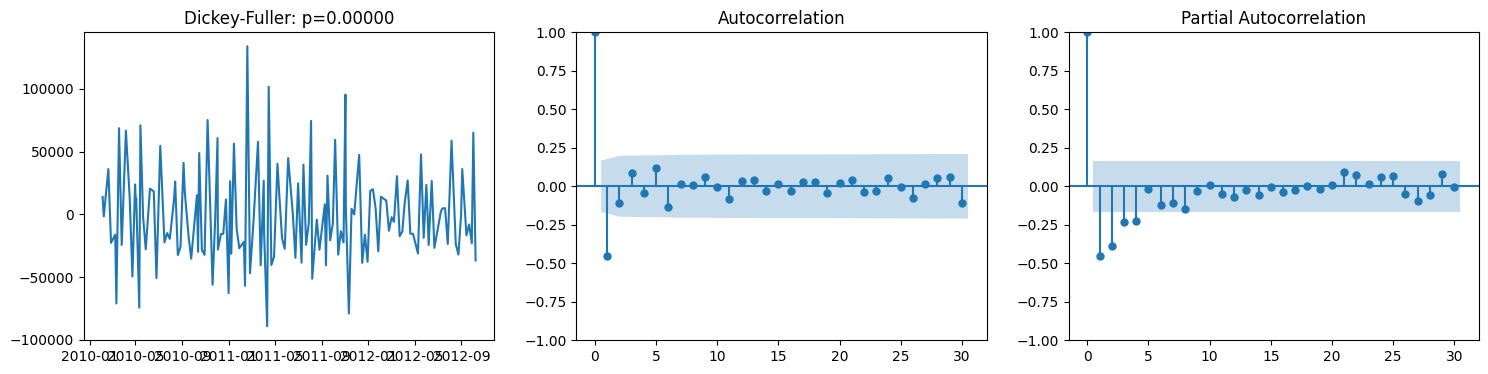

In [ ]:
store_data = dataset[dataset['Store'] == 36].set_index('Date')['Weekly_Sales']



diff_log_store_data = store_data.diff().dropna()

fig, axs = plt.subplots(1, 3, figsize=(18, 4))
tsplot(diff_log_store_data, lags=30, axes=axs)
plt.show()

In [ ]:
def fit_predict_arima(store_id, train_data, test_data, forecast_period=4):
    store_sales = train_data[train_data['Store'] == store_id].set_index('Date')['Weekly_Sales']

    model = SARIMAX(store_sales, 
                    order=(1, 1, 1), 
                    seasonal_order=(1, 1, 1, 52),
                    enforce_stationarity=False, 
                    enforce_invertibility=False)
    
    fitted_model = model.fit(disp=False)
    
    forecast = fitted_model.forecast(steps=forecast_period)
    
    return forecast

submission_results = []

for store in test_data['Store'].unique():
    forecast = fit_predict_arima(store, train_data, test_data)
    
    for i, pred in enumerate(forecast):
        submission_results.append({
            'ID': len(submission_results),  
            'source_attractiveness': pred
        })

submit_df = pd.DataFrame(submission_results)

submit_df.to_csv('submission.csv', index=False)